Comet ML is an experimentation platform, which permits testing Machine Learning projects, from the beginning up to the final monitoring.

Doing ML with Comet is like building with legos. You can customize and combine your data, code, visualizations, reports, and much more to create exactly what you want.

So we start by integrating our notebook with Comet.ml so that we can see everything we will do with our data.


In [3]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="vsNTC2o8UVKvzgsD124nWXkbt",
    project_name="V5 classification-predict-team-4",
    workspace="beebeefaith",
) 

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/beebeefaith/v5-classification-predict-team-4/4693757aca774f2fb7d55db89b80dad4



# Climate Change Belief Analysis 2022


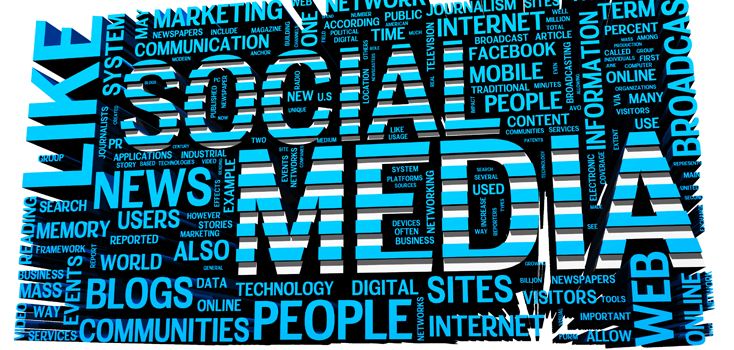

### About the problem

Many companies are built around lessening one’s environmental impact or carbon footprint. They     offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.
                
### The Objective

Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.


Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


                
   
                
                
            


- What is the goal of this? (i.e classify twitter posts as either neutral, factual, etc...)
- Breakdown of the notebook (i.e where you got the data? cleaning it, organizing it, etc)
- What limitations did you face in achieving this?

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>



In [ ]:
#pip install xgboost

In [1]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
import string

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem import PorterStemmer

# Libraries for model building
#import tensorflow
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

# Libraries for data preprocessing and model performance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import confusion_matrix, f1_score,classification_report, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample





<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. 
Each tweet is labelled as one of the following classes:

Class Description
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

In [44]:
# Let us import our test, train and submission data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
samplesubmission = pd.read_csv('sample_submission.csv')

print(train.shape)
print(test.shape)
print(samplesubmission.shape)

(15819, 3)
(10546, 2)
(10546, 2)


From the print above, we have 3 features to work with....
Next, let us get a better view at the content.

In [45]:
train.head(3)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562


In [46]:
test.head(3)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

EDA is Exploratory is a robust technique for familiarising yourself with the Data and extracting useful insights.

EDA is important because besides getting the basic insights and general understanding of our data, we can set the procedure and steps to follow on the entire modelling course.


In [47]:
# Check for null values

train.isnull().any()
test.isnull().any()

message    False
tweetid    False
dtype: bool

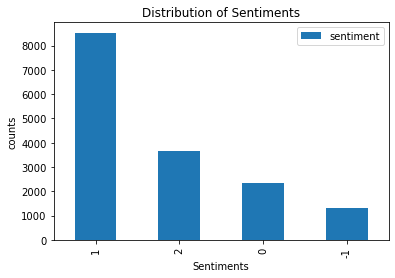

In [3]:
#Lets take a look at the breakdown of sentiments (target variable)

pd.value_counts(train['sentiment']).plot.bar()
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('counts')
plt.legend()
plt.show()

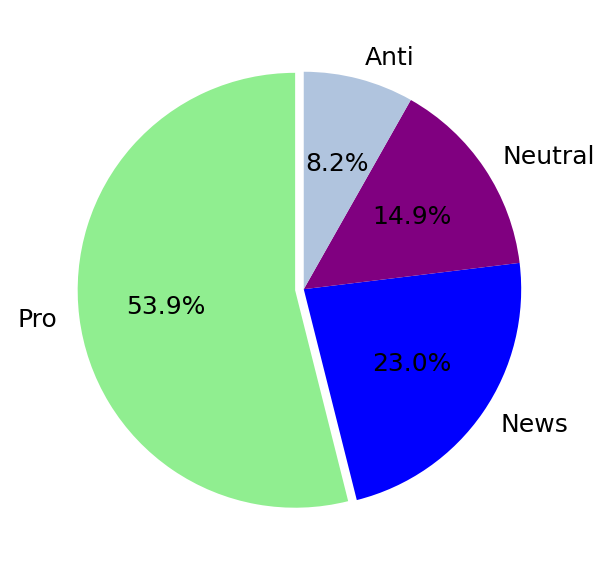

In [86]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

working_df = train.copy()
# Labeling the target
working_df['sentiment'] = [['Anti', 'Neutral', 'Pro', 'News'][x+1] for x in working_df['sentiment']]
# checking the numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['lightgreen', 'blue', 'purple', 'lightsteelblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

######  --Observations--

We can see from the graph above that our sentiments are imbalanced and multiclass.
This might have some impact in the model building. 
We will work on balancing the data later

In [34]:
# Get actual count and statistics of the target variable
train.shape


(15819, 3)

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

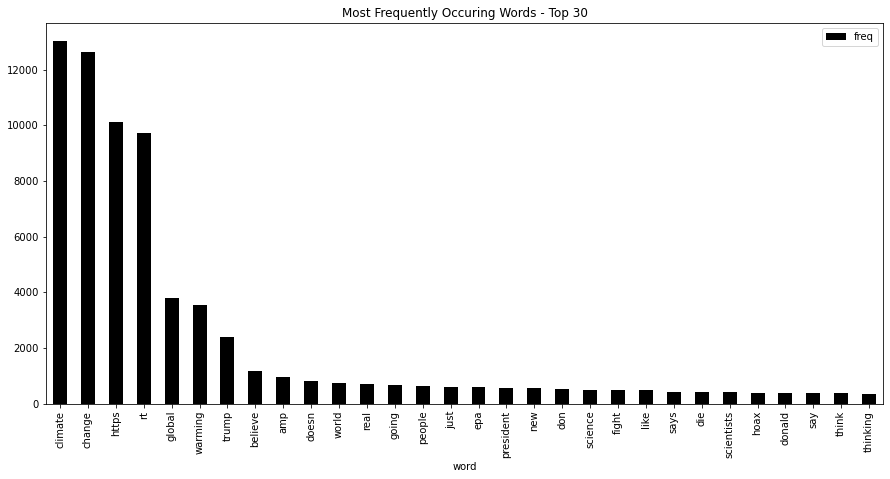

In [49]:
# Lets take a look at the most occuring words in our train dataset


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.message)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'black')
plt.title("Most Frequently Occuring Words - Top 30")

###### Observation
From the graph above, The 6 most frequent words are (climate, change, https, rt, global, warming )

##### Let take a deeper view by building wordclouds for all the different sentiments in our dataset

Text(0.5, 1.0, 'WordCloud - Vocabulary from General Tweets')

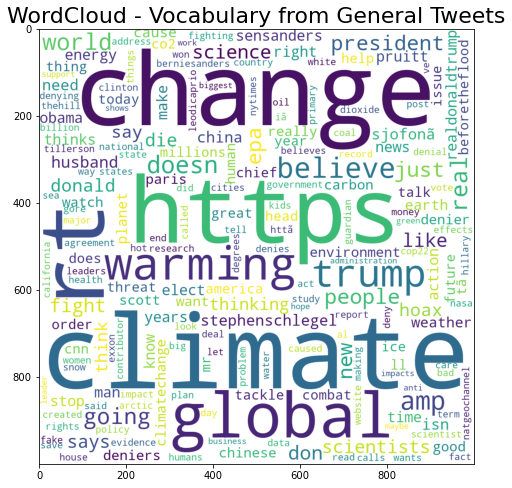

In [50]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from General Tweets", fontsize = 22)

#### From the General Tweets we see that the prominent words are: Climate,change, warming, global, people, president in that descending order

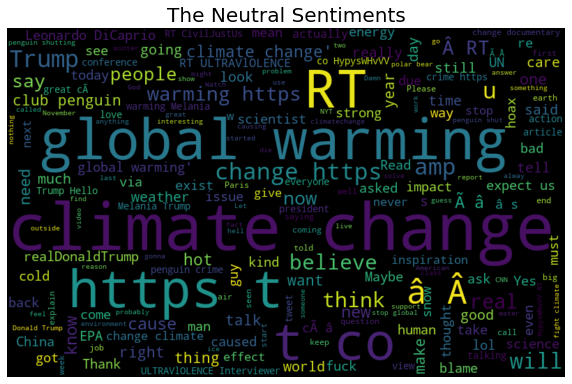

In [37]:
neutral_words =' '.join([text for text in train['message'][train['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Sentiments', fontsize = 20)
plt.show()

From the Neutral Sentiments, we see that 'global warming', 'climate change' are prominent, but 'https','rt','co' though they seem important are part of noise collected while scrapping the data. After cleaning the data they should not be part of the document.

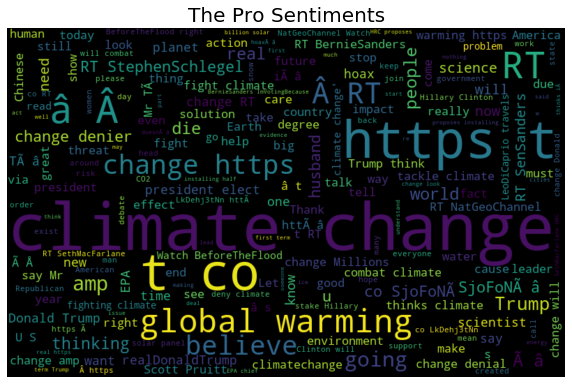

In [38]:
pro_words =' '.join([text for text in train['message'][train['sentiment'] == 1]])

wordcloud = WordCloud( width=800, height=500, random_state = 0, max_font_size = 110).generate(pro_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Pro Sentiments', fontsize = 20)
plt.show()

From the Pro Sentiments, again we see that 'global warming', 'climate change' are prominent, but 'https','rt','co' though they seem important are part of noise collected while scrapping the data. After cleaning the data they should not be part of the document.

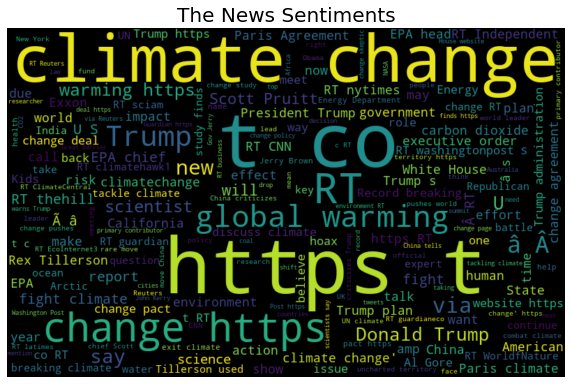

In [39]:
news_words =' '.join([text for text in train['message'][train['sentiment'] == 2]])

wordcloud = WordCloud( width=800, height=500, random_state = 0, max_font_size = 110).generate(news_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The News Sentiments', fontsize = 20)
plt.show()

From the News Sentiments, again we see that 'global warming', 'climate change' are prominent, ,'change' and 'Trump' are also at the top but 'https','rt','co' though they seem important are part of noise collected while scrapping the data. After cleaning the data they should not be part of the document. From this we also learn that the data was collected from the USA, from the mentions of 'Donald Trump','Al Gore', 'White house' we can also tell that the data might also have been collected during Trump's presidency, that is between 2016-2020

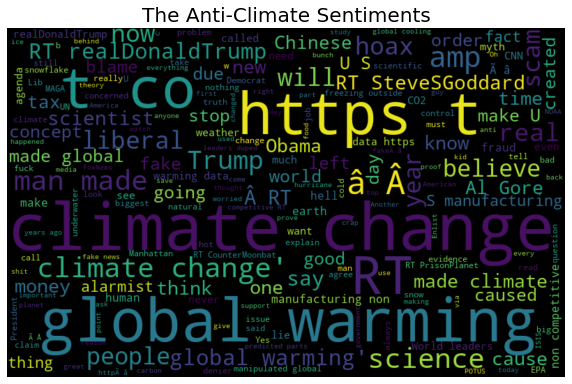

In [40]:
anti_words =' '.join([text for text in train['message'][train['sentiment'] == -1]])

wordcloud = WordCloud( width=800, height=500, random_state = 0, max_font_size = 110).generate(anti_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Anti-Climate Sentiments', fontsize = 20)
plt.show()

From the Anti-climate Sentiments, again we see that 'global warming', 'climate change' are prominent, ,'science','Donald Trump','science','man made' and 'Trump' are also at the top but 'https','rt','co' though they seem important are part of noise collected while scrapping the data. After cleaning the data they should not be part of the document.

#### Observation
###### Across the sentiments, "Climate,Change, Global, Warming" seems to be the most commonly used words. Though the data had no timestamp nor geographical status, from the Wordcloud Analysis we have been able to learn that the data was most probably collected from the USA and the most probable time period would have been during Donald Trump's Presidency, that is between 2016-2020

In [41]:
# Next, lets take a look at our hashtags

def hashtag_extract(x):
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [42]:
# extracting hashtags from News tweets
HT_News = hashtag_extract(train['message'][train['sentiment'] == 2])

# extracting hashtags from Pro tweets
HT_Pro = hashtag_extract(train['message'][train['sentiment'] == 1])

# extracting hashtags from neutral tweets
HT_Neutral = hashtag_extract(train['message'][train['sentiment'] == 0])

# extracting hashtags from anti-climate tweets
HT_Anti = hashtag_extract(train['message'][train['sentiment'] == -1])

# unnesting list
HT_News = sum(HT_News,[])
HT_Pro = sum(HT_Pro,[])
HT_Neutral = sum(HT_Neutral,[])
HT_Anti = sum(HT_Anti,[])

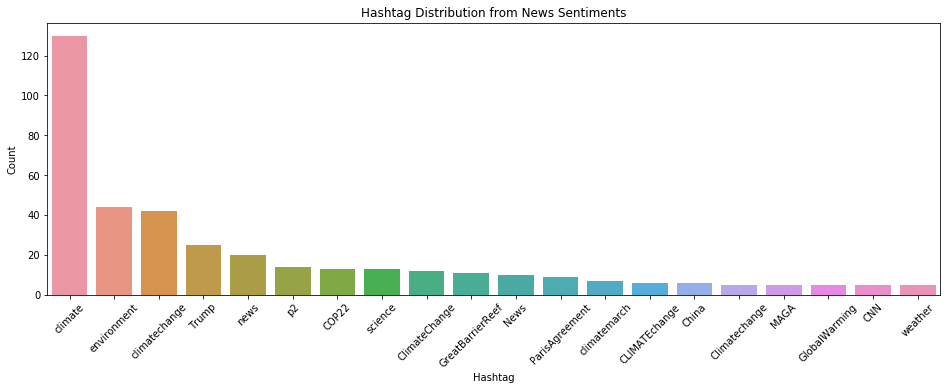

In [43]:
a = nltk.FreqDist(HT_News)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from News Sentiments')
plt.xticks(rotation=45)
plt.show()

From the News Sentiments Hashtag Distribution, 'Climate', 'environment', 'climatechange' and 'Trump' are the most frequent.

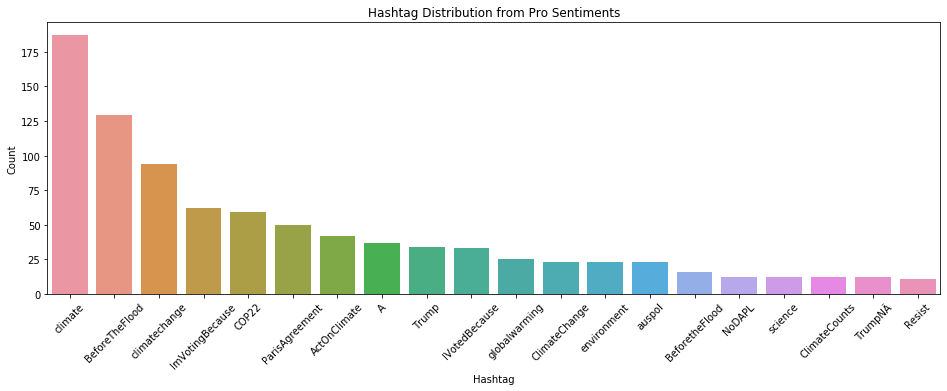

In [44]:
a = nltk.FreqDist(HT_Pro)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from Pro Sentiments')
plt.xticks(rotation=45)
plt.show()

From the Pro Sentiments Hashtag Distribution, 'Climate', 'beforetheflood', 'climatechange' and 'ImVotingBecause' are the most frequent.

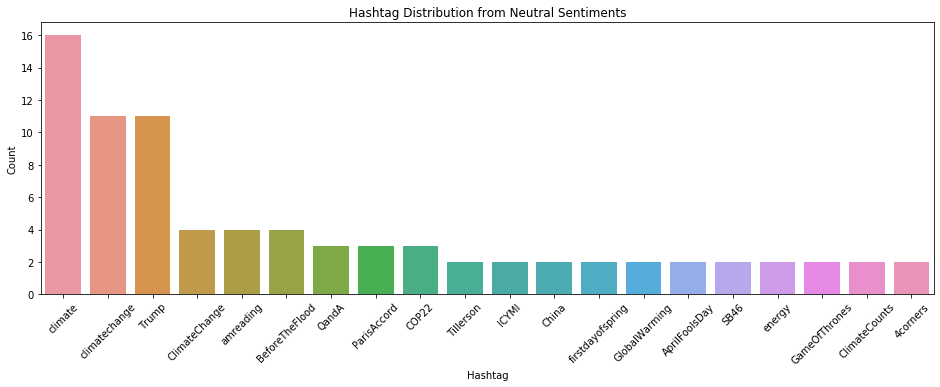

In [45]:
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from Neutral Sentiments')
plt.xticks(rotation=45)
plt.show()

From the Neutral Sentiments Hashtag Distribution, 'Climate', 'climatechange' and 'Trump' are the most frequent.

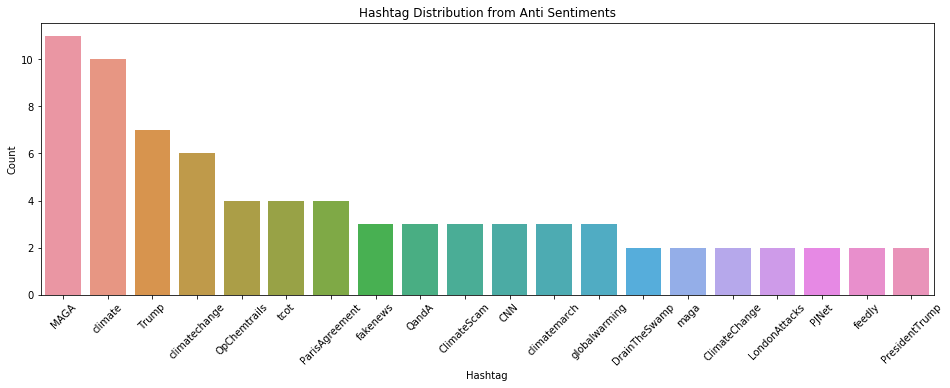

In [46]:
a = nltk.FreqDist(HT_Anti)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from Anti Sentiments')
plt.xticks(rotation=45)
plt.show()

In [ ]:
From the Anti Sentiments Hashtag Distribution,'MAGA' 'Climate', 'Trump' and 'climatechange' are the most frequent.

#### Observations
###### 'Climate' and 'Climatechange' are the most talked about topics in the USA at that time.

###### With 'Trump', 'ImVotingBecause' and 'MAGA'(which stands for Make America Great Again) also in the top 4 most talked about topics helps us reduce the time period to 2019-2020, around the time when last elections were held in the USA.

The EDA, was to give us a better understanding of the data and help us set the next course of action which is Feature engineering.
Next, we move on to the Feature engineering section which is essential because though we have a general understanding of the data, we have seen that the data need to be processed and cleaned, with words like 'https','co','RT', appearing alot on the Wordcloud analysis though they are noise, to enable us gather accurate insights and model the data with precision. 

<a id="four"></a>
## 4. Feature Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


Feature engineering is the process of selecting, manipulating, and transforming raw data into features that can be used in supervised learning. In order to make machine learning work well on new tasks, it might be necessary to design and train better features. The presence of irrelevant characteristics in your Data can reduce the Model accuracy and cause your Model to train based on irrelevant features. In other words, if the features are strong enough, the Machine Learning Algorithm will give fantastic outcomes.

Feature engineering helps to glean better insights, for example with Wordcloud and Hashtag Analysis with the removal of words like 'https' which is noise, would not appear as an important word in all the sentiments analysis.

Feature Engineering is a journey, with some of the steps listed here:
    -Cleaning the data which entails removing URLS, word capitalization, punctuations, Non Ascii and Stopwords removal
    -Feature Selection which entails creating new features and dropping irrelevant ones if necessary
    -Handling missing values if there are any
    -Handling imbalanced data which helps in removing biases in the model
    -Handling outliers if there are any
    -Encoding the features or label to help train the model better, by transforming features and labels to the integer datatype.
    -Feature Scaling helps to train the model better as it puts the all the different features on the same scale hence we can analyse the relationships better, by reducing the variance effect

Walk with us as we learn and model the data, with each step getting us closer to our goal of efficiently predicting with precision our data.

### Here, we will clean up our train and test data, and get them ready for model building and testing

We First remove noise gathered while scrapping the data from the web, words like 'htttps' that seem important because of how frequent they are and yet are irrelevant to the model.

In [51]:
## Remove urls
print ('Removing URLs...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-link'
train['clean'] = train['message'].replace(to_replace = pattern_url, value = '', regex = True)

## Remove urls test

pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-link'
test['clean'] = test['message'].replace(to_replace = pattern_url, value = '', regex = True)

Removing URLs...


Then we lowercase our data so that words like 'ClimateChange' and 'climatechange' are not counted as different in our model.

In [52]:
# Make lower case

train['clean'] = train['clean'].str.lower()
test['clean'] = test['clean'].str.lower()

Then we remove puntuation, so that Sentiments are gotten from actual and relevant words or tokens.

In [53]:
#Punctuations removal:

def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
train['clean'] = train['clean'].apply(remove_punctuation_numbers)
test['clean'] = test['clean'].apply(remove_punctuation_numbers)

In [54]:
#Removed NonAscii

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

train['clean'] = train['clean'].apply(_removeNonAscii)
test['clean'] = test['clean'].apply(_removeNonAscii)

Stemming helps our model by removing words that appear in many formats but still represent the base word, helps us to get a clean representation of relevant words. 

In [55]:
# Clean the word using stemming
stema = PorterStemmer()
train['clean'] = [stema.stem(word) for word in train['clean']]
test['clean'] = [stema.stem(word) for word in test['clean']]


Stopwords are removed because they are frequent but are not relevant to the topic at hand, and can lead to inaccurate insights

In [57]:
#Stopword removal:

train['clean'] = [word for word in train['clean'] if word not in ENGLISH_STOP_WORDS]
test['clean'] = [word for word in test['clean'] if word not in ENGLISH_STOP_WORDS]


In [64]:
train['clean'] = train['clean'].replace(to_replace = ["its","doesnt",'rt','isnt','youre','dont','not'], value = '', regex = True)
test['clean'] = test['clean'].replace(to_replace = ["its","doesnt",'rt','isnt','youre','dont','not'], value = '', regex = True)

In [65]:
#Remove words with 1 or 2 chars
text_1 = r'\b\w{1,2}\b'
train['clean'] = train['clean'].replace(to_replace = text_1, value = '', regex = True )
test['clean'] = test['clean'].replace(to_replace = text_1, value = '', regex = True )

We now take a look at how our data looks like after the cleaning process is complete

In [66]:
train.head()

,sentiment,message,tweetid,clean
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warm
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say have three years a...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired was pivotal year the wa...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas and racist sexist climate ...


We head on over to Feature selection, and we start with creation of new relevant features...

We start by creating a 'new_len' feature that gives us the number of elements(total number of characters) in the new column 'clean'

In [67]:
#Adding length of cleaned tweet to dataset
train['new_len']= train['clean'].apply(lambda x:len(x))
test['new_len']= test['clean'].apply(lambda x:len(x))
train.head()

,sentiment,message,tweetid,clean,new_len
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ...,96
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warm,48
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say have three years a...,83
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired was pivotal year the wa...,64
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas and racist sexist climate ...,100


Then we create a new 'word_count' column that gives the number of words per 'clean' column

In [68]:
# Function that returns number of words in a string
def count_words(string):
# Split the string into words
    words = string.split()    
    # Return the number of words
    return len(words)
# Create a new feature word_count
train['word_count'] = train['clean'].apply(count_words)
test['word_count'] = test['clean'].apply(count_words)

Then we create a new 'hashtag_count' column that gives the number of hashtags found in the 'message' column

In [69]:
# Function that returns numner of hashtags in a string
def count_hashtags(string):
	# Split the string into words
    words = string.split()    
    # Create a list of words that are hashtags
    hashtags = [word for word in words if word.startswith('#')]    
    # Return number of hashtags
    return(len(hashtags))

# Create a feature hashtag_count and display distribution
train['hashtag_count'] = train['message'].apply(count_hashtags)
test['hashtag_count'] = test['message'].apply(count_hashtags)

Then we create a new 'stop_count' column that gives the number of stopwords found in the column 'message' per row

In [70]:
# Function that returns number of stopwords in a string
def count_stopwords(string):
	# Split the string into words
    words = string.split()    
    # Create a list of words that are stopwords
    stop_w = [word for word in words if word in ENGLISH_STOP_WORDS]    
    # Return number of stopwords
    return(len(stop_w))

# Create a feature hashtag_count and display distribution
train['stop_count'] = train['message'].apply(count_stopwords)
test['stop_count'] = test['message'].apply(count_stopwords)

Then we create a new 'count_mention' column that gives the number of mentions found in the column 'message' per row

In [71]:
# Function that returns number of mentions in a string
def count_mentions(string):
	# Split the string into words
    words = string.split()    
    # Create a list of words that are mentions
    mentions = [word for word in words if word.startswith('@')]    
    # Return number of hashtags
    return(len(mentions))
# Create a feature hashtag_count and display distribution
train['mention_count'] = train['message'].apply(count_mentions)
test['mention_count'] = test['message'].apply(count_mentions)

This step we combine a bunch of steps. These include creating the following columns:
    -'qnt_unique_words' that gives the number of unique words found in the 'clean' column per row
    -'qnt_chars' that gives the number of characters found in the 'message' column per row
    -'qnt_punctuation' this first replaces the punctuations found and gives the count of the puntuations replaced in the 'message' column per row
    -'qnt_urls' that gives the number of urls found in the 'message' column per row 
    -'mean-chars_words' that gives the mean of the count of characters in words found in the 'message' column per row

In [72]:
re_url = r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'

train['qnt_unique_words'] = train['clean'].str.split().apply(lambda x : len(set(x)))
train['qnt_chars'] = train['message'].str.len()
train['qnt_punctuation'] = train['message'].str.replace(r'[\w\s#]+', '').apply(lambda x : len(x))
train['qnt_urls'] = train['message'].str.findall(re_url).apply(lambda x : len(x))
train['mean_chars_words'] = train['message'].str.split().apply(lambda x: np.mean([len(w) for w in x]))

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


Now, we look at how our Train data looks like...

In [73]:
train.head(3)

,sentiment,message,tweetid,clean,new_len,word_count,hashtag_count,stop_count,mention_count,qnt_unique_words,qnt_chars,qnt_punctuation,qnt_urls,mean_chars_words
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ...,96,15,0,3,1,15,140,12,1,6.421053
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warm,48,6,0,3,0,6,62,1,0,5.300000
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say have three years a...,83,12,0,7,1,12,140,14,2,6.421053


We carry out the same steps to our Test data

In [74]:
test['qnt_unique_words'] = test['clean'].str.split().apply(lambda x : len(set(x)))
test['qnt_chars'] = test['message'].str.len()
test['qnt_punctuation'] = test['message'].str.replace(r'[\w\s#]+', '').apply(lambda x : len(x))
test['qnt_urls'] = test['message'].str.findall(re_url).apply(lambda x : len(x))
test['mean_chars_words'] = test['message'].str.split().apply(lambda x: np.mean([len(w) for w in x]))

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
pd.value_counts(train['word_count']['sentiments'] == 0).plot.bar()
plt.show()

KeyError: 'sentiments'

We look at how our Test and train Data is shaping up...

In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   message           10546 non-null  object 
 1   tweetid           10546 non-null  int64  
 2   clean             10546 non-null  object 
 3   new_len           10546 non-null  int64  
 4   word_count        10546 non-null  int64  
 5   hashtag_count     10546 non-null  int64  
 6   stop_count        10546 non-null  int64  
 7   mention_count     10546 non-null  int64  
 8   qnt_unique_words  10546 non-null  int64  
 9   qnt_chars         10546 non-null  int64  
 10  qnt_punctuation   10546 non-null  int64  
 11  qnt_urls          10546 non-null  int64  
 12  mean_chars_words  10546 non-null  float64
dtypes: float64(1), int64(10), object(2)
memory usage: 1.0+ MB


In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sentiment         15819 non-null  int64  
 1   message           15819 non-null  object 
 2   tweetid           15819 non-null  int64  
 3   clean             15819 non-null  object 
 4   new_len           15819 non-null  int64  
 5   word_count        15819 non-null  int64  
 6   hashtag_count     15819 non-null  int64  
 7   stop_count        15819 non-null  int64  
 8   mention_count     15819 non-null  int64  
 9   qnt_unique_words  15819 non-null  int64  
 10  qnt_chars         15819 non-null  int64  
 11  qnt_punctuation   15819 non-null  int64  
 12  qnt_urls          15819 non-null  int64  
 13  mean_chars_words  15819 non-null  float64
dtypes: float64(1), int64(11), object(2)
memory usage: 1.7+ MB


#### We regenerate our WordClouds on our different Sentiments and capture the difference 

We start with the Neutral Sentiments

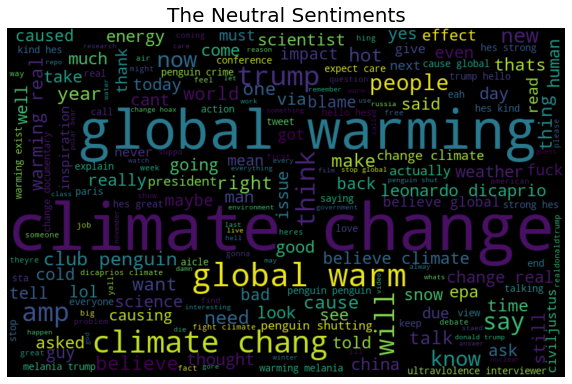

In [77]:
neutral_words =' '.join([text for text in train['clean'][train['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Sentiments', fontsize = 20)
plt.show()

Now we see that 'https' is no longer a word, but 'Climate', 'change', 'global', 'warming' and 'rt' are still key words.
'rt' is a relevant stop word in politics which means Right Honourable

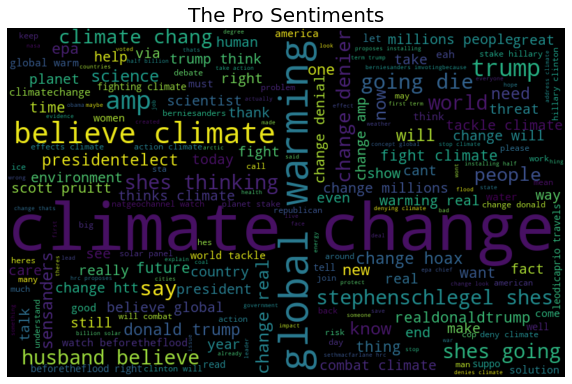

In [78]:
# Then we do the same for Pro Sentiment
pro_words =' '.join([text for text in train['clean'][train['sentiment'] == 1]])

wordcloud = WordCloud( width=800, height=500, random_state = 0, max_font_size = 110).generate(pro_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Pro Sentiments', fontsize = 20)
plt.show()

Again we see words like 'climate', 'change' 'global', 'warming' are key and the 'https' word has disappeared.

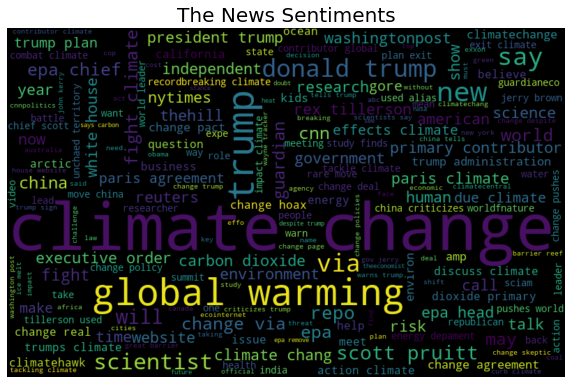

In [79]:
# Then we do the same for News Sentiment
news_words =' '.join([text for text in train['clean'][train['sentiment'] == 2]])

wordcloud = WordCloud( width=800, height=500, random_state = 0, max_font_size = 110).generate(news_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The News Sentiments', fontsize = 20)
plt.show()

Again we see words like 'climate', 'change' 'global', 'warming' are key and the 'https' word has disappeared.

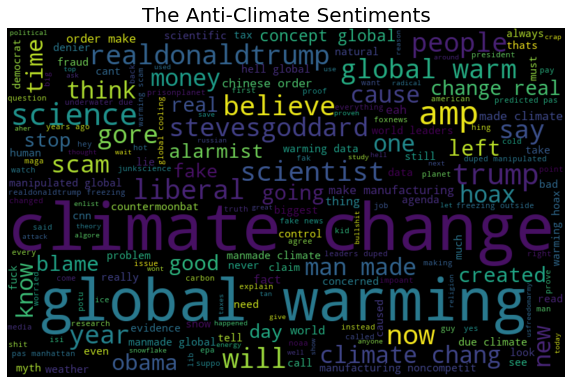

In [80]:
#Finally, we do the same for Anti Sentiment
anti_words =' '.join([text for text in train['clean'][train['sentiment'] == -1]])

wordcloud = WordCloud( width=800, height=500, random_state = 0, max_font_size = 110).generate(anti_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Anti-Climate Sentiments', fontsize = 20)
plt.show()

Again we see words like 'climate', 'change' 'global', 'warming' are key and the 'https' word has disappeared, and been replaced with 'Urllink'word.

With Feature Engineering complete, we are on way to getting better, accurate insights and developing a model that is precise.


Feature engineering has created relevant features that would help us better model the data.

Next we move on to Modelling, which is main processs, to be able to predict text to various sentiments. 

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Data Modelling is the incorporation Machine Learning Algorithms to the data.

This is one of the most crucial processes in Data Science Modelling as the Machine Learning Algorithm aids in creating a usable Data Model. There are a lot of algorithms to pick from, the Model selected is based on the problem at hand, that is the prediction of the sentiment given a text.

Here again, we follow  a process and the goal is to come up with atleast 4 models that we can assess their performance and choose one that is the best, in terms of efficiency ie memory and train run time used and of course, it's precision.



In [72]:
# We start by splitting the Data into X and Y
train1 = train.copy()
X = train1['clean']
y = train1['sentiment']

In [73]:
# Then we create bag of words, this is to transform the features into vectors, so that we can be able to model the data better

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2)
# fit the model for training data
X = vectorizer.fit_transform(X)

print(X.shape)
print(y.shape)

(15819, 32524)
(15819,)


In [74]:
# Then do the same for the test data
x_test = test['clean']
x_t =vectorizer.transform(x_test)


print(x_t.shape)

(10546, 32524)


In [75]:
# Split the X data into train and valid 

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 42)

The 4 Classifiers we will use will be:

    -Logistic Regression which is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable.
    
    -Multinomial Naive Bayes which is an algorithm based on applying Bayes theorem with a strong(naive) assumption, that every feature is independent of the others, in order to predict the category of a given sample.
    
    -Bagging Classifier which is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. It has a base_estimator parameter whose default is set to DecisionTreeClassifier.
    
    -Random Forest is also a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

#### Let's build some classification models! 

These models are based on the unbalanced data we had. So we are to compare results of before and after resampling(more on this later) is done

In [76]:
names = ['Logistic Regression', 'Multinomial NaiveB',          
         'BaggingClassifier', 'Random Forest']

In [77]:
# Notice we put our base_estimator as Logistic Regression classifier for our Bagging Classifier
classifiers = [
    LogisticRegression(), 
    MultinomialNB(),
    BaggingClassifier(base_estimator = LogisticRegression()),
    RandomForestClassifier() 
]

In [78]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(x_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(x_train)   
    y_pred_test = clf.predict(x_valid)
    
    print ('... scoring')
    accuracy  = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred,average="macro")
    recall    = recall_score(y_train, y_pred,average="macro")
    
    f1        = f1_score(y_train, y_pred,average="macro")    
    f1_test   = f1_score(y_valid, y_pred_test,average="macro")    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = confusion_matrix(y_train, y_pred)
    class_report[name] = classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



... predicting
... scoring
Fitting Multinomial NaiveB model...
... predicting
... scoring
Fitting BaggingClassifier model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\

... predicting
... scoring
Fitting Random Forest model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



... predicting
... scoring
... All done!


As we had seen earlier, our data was imbalanced. This means that our 4 sentiments were not evenly distributed. And if we were to train our model on this data, the model would be biased to predict the sentimnets that were more, as we will soon see in our findings as it affects our precision results.

So how do we handle Class imbalance?

Our solution, Resampling which is simply, resampling methods involve modifying the number of observations in each class as follows:

Downsampling - taking a random subset of the majority class small enough to match the number of observations in the minority class.

Upsampling - taking repeated random samples from the minority class until we have as many observations as the majority class. This grows the size of the minority class by effectively duplicating observations at random.

#### BUILDING MODELS WITH DOWNSAMPLED DATA

In [79]:
# Separate the classes classes
train2 = train.copy()
neutral = train2[train2['sentiment']==0]
pro = train2[train2['sentiment']==1]
news = train2[train2['sentiment']==2]
anti = train2[train2['sentiment']== -1]

base = 1500

In [80]:
# Downsample SENTIMENTS
neutral_sampled2 = resample(neutral,
                          replace=False, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27) # reproducible results

pro_sampled2 = resample(pro,
                          replace=False, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27) # reproducible results

news_sampled2 = resample(news,
                          replace=False, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27)

anti_sampled2 = resample(anti,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27)

In [81]:
# Combine downsampled classes
train2 = pd.concat([neutral_sampled2, pro_sampled2,news_sampled2,anti_sampled2])

train2['sentiment'].value_counts()

-1    1500
 2    1500
 1    1500
 0    1500
Name: sentiment, dtype: int64

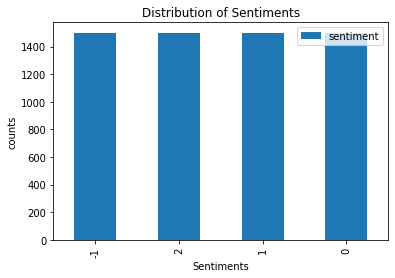

In [82]:
#Lets take a look at the breakdown of sentiments (target variable)

pd.value_counts(train2['sentiment']).plot.bar()
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('counts')
plt.legend()
plt.show()

### Lets build new models with the resampled data

Following the same process

In [83]:
# We Split the Data into X and Y
X2 = train2['clean']
y2 = train2['sentiment']

In [84]:
# Then we create bag of words this time with the TfIdf Vectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
# fit the model for training data
X2= vectorizer.fit_transform(X2)

print(X2.shape)
print(y2.shape)

(6000, 16708)
(6000,)


In [85]:
# And do the same for the test data
x_test = test['clean']
x_t =vectorizer.transform(x_test)


print(x_t.shape)

(10546, 16708)


In [86]:
# We split the X data into train and valid 

x_train2, x_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size = 0.20, random_state = 42)

In [87]:
names2 = ['Logistic Regression', 'Multinomial NaiveB',          
         'BaggingClassifier', 'Random Forest']

In [104]:
# Notice we put our base_estimator as Logistic Regression classifier for our Bagging Classifier
classifiers2 = [
    LogisticRegression(), 
    MultinomialNB(),
    BaggingClassifier(base_estimator = LogisticRegression()),
    RandomForestClassifier()    
    
]

In [105]:
results_2 = []

models_2 = {}
confusion_2 = {}
class_report_2 = {}


for name2, clf2 in zip(names2, classifiers2):    
    print ('Fitting {:s} model...'.format(name2))
    run_time2 = %timeit -q -o clf2.fit(x_train2, y_train2)
    
    print ('... predicting')
    y_pred2 = clf2.predict(x_train2)   
    y_pred_test2 = clf2.predict(x_valid2)
    
    print ('... scoring')
    accuracy2  = accuracy_score(y_train2, y_pred2)
    precision2 = precision_score(y_train2, y_pred2,average="macro")
    recall2    = recall_score(y_train2, y_pred2,average="macro")
    
    f12        = f1_score(y_train2, y_pred2,average="macro")    
    f1_test2   = f1_score(y_valid2, y_pred_test2,average="macro")    
    
    # Save the results to dictionaries
    models_2[name2] = clf2    
    confusion_2[name2] = confusion_matrix(y_train2, y_pred2)
    class_report_2[name2] = classification_report(y_train2, y_pred2)
    
    results_2.append([name2, accuracy2, precision2, recall2, f12, f1_test2, run_time2.best])

    
results_2 = pd.DataFrame(results_2, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results_2.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



... predicting
... scoring
Fitting Multinomial NaiveB model...
... predicting
... scoring
Fitting BaggingClassifier model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\

... predicting
... scoring
Fitting Random Forest model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



... predicting
... scoring
... All done!


#### BUILDING MODELS WITH UPSAMPLED DATA

And once again follow the same process

In [89]:
# Separate the classes classes
train3 = train.copy()
neutral = train3[train3['sentiment']==0]
pro = train3[train3['sentiment']==1]
news = train3[train3['sentiment']==2]
anti = train3[train3['sentiment']== -1]

base = 5000

In [90]:
# UPSAMPLE SENTIMENTS
neutral_sampled3 = resample(neutral,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27) # reproducible results

pro_sampled3 = resample(pro,
                          replace=False, # sample with replacement (we dont need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27) # reproducible results

news_sampled3 = resample(news,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27)

anti_sampled3 = resample(anti,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= base, # match number in minority class
                          random_state=27)

In [91]:
# Combine downsampled classes
train3 = pd.concat([neutral_sampled3, pro_sampled3,news_sampled3,anti_sampled3])

train3['sentiment'].value_counts()

-1    5000
 2    5000
 1    5000
 0    5000
Name: sentiment, dtype: int64

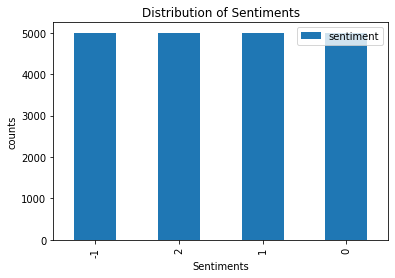

In [92]:
#Lets take a look at the breakdown of sentiments (target variable)

pd.value_counts(train3['sentiment']).plot.bar()
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('counts')
plt.legend()
plt.show()

#### Let's build models with our upsampled data

In [93]:
# Once again we split the Data into X and Y
X3 = train3['clean']
y3 = train3['sentiment']

In [94]:
# Then we vectorizze the data using TfIdf Vectorizer

vectorizer3 = TfidfVectorizer(ngram_range=(1,2), min_df=2)
# fit the model for training data
X3 = vectorizer3.fit_transform(X3)

print(X3.shape)
print(y3.shape)

(20000, 52959)
(20000,)


In [95]:
# Then vectorize the test data
x_test = test['clean']
x_t =vectorizer3.transform(x_test)


print(x_t.shape)

(10546, 52959)


In [96]:
# Then we split the X data into train and valid 

x_train3, x_valid3, y_train3, y_valid3 = train_test_split(X3, y3, test_size = 0.20, random_state = 42)

In [97]:
names3 = ['Logistic Regression', 'Multinomial NaiveB',          
         'BaggingClassifier', 'Random Forest']

In [98]:
# Notice we put our base_estimator as Logistic Regression classifier for our Bagging Classifier
classifiers3 = [
    LogisticRegression(), 
    MultinomialNB(),
    BaggingClassifier(base_estimator = LogisticRegression()),
    RandomForestClassifier()
]

In [99]:
results_3 = []

models_3 = {}
confusion_3 = {}
class_report_3 = {}


for name3, clf3 in zip(names3, classifiers3):    
    print ('Fitting {:s} model...'.format(name3))
    run_time3 = %timeit -q -o clf3.fit(x_train3, y_train3)
    
    print ('... predicting')
    y_pred3 = clf3.predict(x_train3)   
    y_pred_test3 = clf3.predict(x_valid3)
    
    print ('... scoring')
    accuracy3  = accuracy_score(y_train3, y_pred3)
    precision3 = precision_score(y_train3, y_pred3,average="macro")
    recall3    = recall_score(y_train3, y_pred3,average="macro")
    
    f13        = f1_score(y_train3, y_pred3,average="macro")    
    f1_test3   = f1_score(y_valid3, y_pred_test3,average="macro")    
    
    # Save the results to dictionaries
    models_3[name3] = clf3    
    confusion_3[name3] = confusion_matrix(y_train3, y_pred3)
    class_report_3[name3] = classification_report(y_train3, y_pred3)
    
    results_3.append([name3, accuracy3, precision3, recall3, f13, f1_test3, run_time3.best])

    
results_3 = pd.DataFrame(results_3, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results_3.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



... predicting
... scoring
Fitting Multinomial NaiveB model...
... predicting
... scoring
Fitting BaggingClassifier model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\

... predicting
... scoring
Fitting Random Forest model...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



... predicting
... scoring
... All done!


We have our models on 3 sets of data: 
    -the imbalanced data
    -downsampled data
    -upsampled data
    
We proceed to check the performance of our models.

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

For our model performance we will consider the following metrics - Accuracy, Precision, Recall and F1-score

### ACCURACY
This is simply the proportion of correct prediction to the total prediction. 

         Accuracy =  Correct predictions / Total predictions

### PRECISION
Precision answers the question of “what proportion of predicted positives in a class are truly postitive in that class? 

         Precision =  TP / TP + FP

### RECALL
When the outcome is actually yes, how often do we predict it as such?

         Precision =  TP / TP + FN

### F1-SCORE

It is calculated by taking the harmonic mean of precision and recall and ranges from 0 to 1. It is a more robust measure especiall for imbalanced data.

#### Lets see how the general Imbalanced data performed

In [100]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Logistic Regression,0.987278,0.987690,0.981690,0.984621,0.686199,2.956658
Random Forest,0.987515,0.989644,0.979505,0.984477,0.554548,4.465663
BaggingClassifier,0.952035,0.961485,0.922342,0.940319,0.672695,29.090724
Multinomial NaiveB,0.870170,0.875693,0.821999,0.842194,0.646824,0.016405


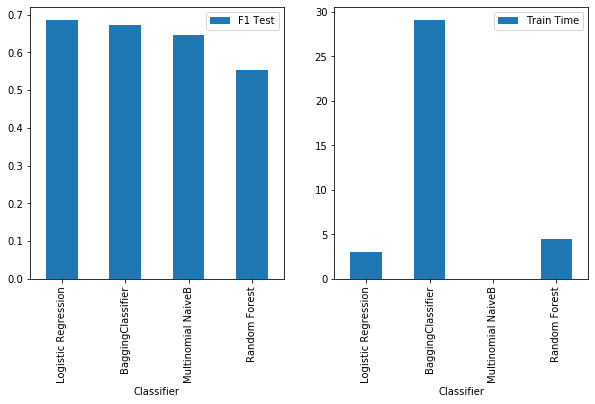

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Test', ascending=False, inplace=True)
results.plot(y='F1 Test', kind='bar', ax=ax[0], xlim=[0,1.1])
results.plot(y='Train Time', kind='bar', ax=ax[1])

From the Graph above, 
- Our F1-score ranges between 0.5 - 0.6 across the 4 models, despite the high value across other metrics.
- Random Forest took the most train time and NaiveBayes the least.

### Let us see how our down-sampled data performed

In [106]:
results_2.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Random Forest,0.989583,0.989537,0.989611,0.989555,0.630361,0.909161
Multinomial NaiveB,0.906875,0.909213,0.906500,0.906985,0.724774,0.005003
Logistic Regression,0.885625,0.888032,0.885287,0.884972,0.711207,0.224639
BaggingClassifier,0.872708,0.875348,0.872389,0.871963,0.697712,2.430293


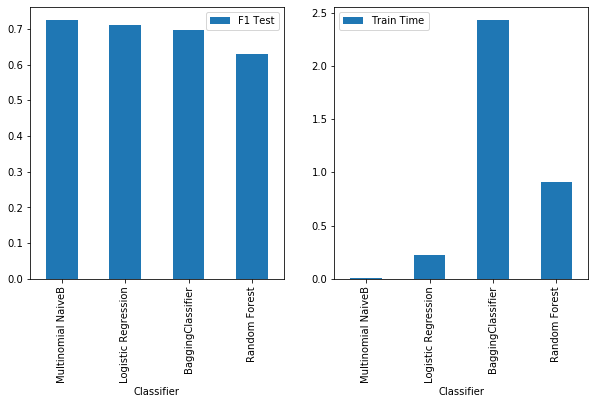

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results_2.sort_values('F1 Test', ascending=False, inplace=True)
results_2.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1])
results_2.plot(y='Train Time', kind='bar', ax=ax[1])

From the Graph above, 
- Our F1-score ranges between 0.6 - 0.7 across the 4 models for unseen data, this is a significant improvement from the previous performance
- BaggingClassifier took the most train time and NaiveBayes the least.

### Let us see how our Up-sampled data performed

In [108]:
results_3.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Random Forest,0.995250,0.995242,0.995242,0.995241,0.887960,5.534138
Logistic Regression,0.941750,0.942186,0.941615,0.941393,0.880235,1.524521
Multinomial NaiveB,0.939750,0.941468,0.939706,0.939813,0.873884,0.017102
BaggingClassifier,0.932562,0.933008,0.932402,0.932019,0.874000,14.561142


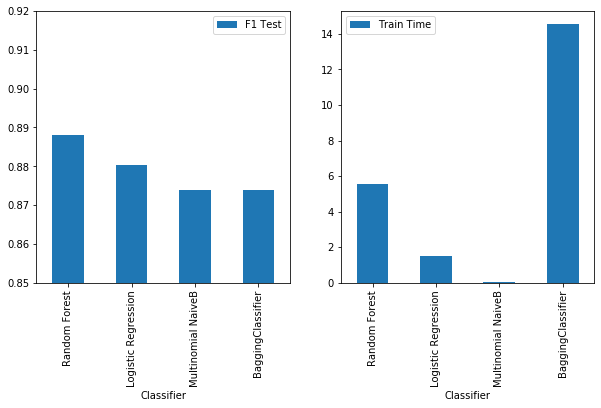

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results_3.sort_values('F1 Train', ascending=False, inplace=True)
results_3.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
results_3.plot(y='Train Time', kind='bar', ax=ax[1])

From the Graph above, 
- Our F1-score ranges between 0.7 - 0.9 across the 4 models for unseen data, this is a significant improvement from the previous performance
- RandomForest took the most train time and NaiveBayes the least.

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

We first start with Random Forest Classifier: It was the best in terms of precision but took the most train time, so there is a trade-off. 

Logistic Regression: Had a good F1 score and the train time was also good. This trade-off between train time and precision is workable and we considered it as the best performing among the classifiers that we used.
    

Multinomial Naive Bayes: Had the worst F1 score but the least train time. The question would be; would you rather have relatively many wrong predictions but with less train time? 
For us precision is key and so we deemed it the worst performing.

And finally, the Bagging Classifier: It had the worst train time, probably because it is an ensemble classifier and also a not so good F1 score. For us we didnot pick it as our winner.

In conclusion, working with imbalanced data is unwise as we have seen, our F1 score ranged between 0.5-0.6 
And betwwen upsampling and downsampling, upsampling with our data was magic, with our F1 score range of 0.87-0.88

### Prepare Kaggle submission data from the models
##### We will use the upsampled data

In [110]:
rf = RandomForestClassifier()

In [111]:
lgr = LogisticRegression(C=10)
m_nb = MultinomialNB()
bgc = BaggingClassifier(lgr)

In [112]:
bgc.fit(X3,y3)
m_nb.fit(X3,y3)
lgr.fit(X3,y3)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
rf.fit(X3,y3)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
rf1_pred = rf.predict(x_t)

In [115]:
lg1_pred = lgr.predict(x_t)
m_nb_pred = m_nb.predict(x_t)
bgc_1 = bgc.predict(x_t)

In [116]:
sub_file1 = samplesubmission.copy()

sub_file1.sentiment = rf1_pred
sub_file1.to_csv("rf_00.csv", index = False)

In [117]:
# # Create a submission file xgb
sub_file1 = samplesubmission.copy()

sub_file1.sentiment = rf1_pred
sub_file1.to_csv("rf_00.csv", index = False)

sub_file2 = samplesubmission.copy()

sub_file2.sentiment = lg1_pred
sub_file2.to_csv("lg_66.csv", index = False)

sub_file5 = samplesubmission.copy()

sub_file5.sentiment = bgc_1
sub_file5.to_csv("bgc_55.csv", index = False)

sub_file4 = samplesubmission.copy()

sub_file4.sentiment = m_nb_pred
sub_file4.to_csv("nb_55.csv", index = False)

### Let us create pickle files of our various models for deployment

In [118]:
# Pickle random forest model for use within our API  
import pickle 

save_path = 'twitter_simple_rf_model.pkl'
print (f"Training completed. Saving model to: {save_path}")
pickle.dump(rf, open(save_path,'wb'))

save_path = 'twitter_simple_lg_model_2.pkl'
print (f"Training completed. Saving model to: {save_path}")
pickle.dump(lgr, open(save_path,'wb'))

save_path = 'twitter_simple_naive_bayes_model_2.pkl'
print (f"Training completed. Saving model to: {save_path}")
pickle.dump(m_nb, open(save_path,'wb'))

save_path = 'twitter_simple_bag_model_2.pkl'
print (f"Training completed. Saving model to: {save_path}")
pickle.dump(bgc, open(save_path,'wb'))


Training completed. Saving model to: twitter_simple_rf_model.pkl
Training completed. Saving model to: twitter_simple_lg_model_2.pkl
Training completed. Saving model to: twitter_simple_naive_bayes_model_2.pkl
Training completed. Saving model to: twitter_simple_bag_model_2.pkl


### In Conclusion


In this notebook, we explored the twitter climate change dataset, and used 4 classifiers to model the data, namely:
    -Logistic Regression Classifier
    -Bagging Classifier
    -Random Forest Classifier
    -Multinomial Naive Bayes Classifier
We took note of the fact:
    -It is key to have balanced data for modelling
    -There's trade-off to consider between precision and training time of the models when choosing a model to implement.
    -Random Forest had the best F1 score(of 0.887960 ) but the longest training time, whereas Logistic regression had the second highest F1 score and a not so bad training time, which is why we chose it as our best performing model.
    -We did not perform hyperparameter tuning because running the notebook cells was taking to much time(Our computers need an upgrade).

Limitations; As we clearly saw earlier, the data was collected from the USA during their last campaign period, that is between 2018-2020, the model though perfect and amazing, it can not be used in other parts of the world due to the economic and geographical differences and also the time period(the campaigning period) also limits it a time where people are very vocal about was is wrong in their world, and where they would want to see change and action. 


In [89]:
# We end the experiment on Comet.ml 
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/beebeefaith/v5-classification-predict-team-4/327537ff41424615b8644adbf1d8a36c
COMET INFO:   Parameters:
COMET INFO:     C                                 : 1.0
COMET INFO:     alpha                             : 1.0
COMET INFO:     base_estimator                    : LogisticRegression()
COMET INFO:     base_estimator__C                 : 1.0
COMET INFO:     base_estimator__class_weight      : 1
COMET INFO:     base_estimator__dual              : False
COMET INFO:     base_estimator__fit_intercept     : True
COMET INFO:     base_estimator__intercept_scaling : 1
COMET INFO:     base_estimator__l1_ratio          : 1
COMET INFO:     base_estimator__max_iter          : 100
COMET INFO:     base_estimator__multi_class       : auto
COMET INFO:     base_e